In [1]:
import sys
sys.path.append("..")

import torch
import json
import cv2
import numpy as np
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import utils_file
from scipy.ndimage import gaussian_filter

class KeyPoseDataset(Dataset):
    def __init__(self, img_path, annotate_path, transform=None):
        annotation_file = json.load(open(annotate_path, "rb"))
        self.annotations = annotation_file['annotations']
        self.img_path = img_path
        self.transform = transform
        
        self.input_width = 192
        self.input_height = 256
        
        self.heatmap_width = 48
        self.heatmap_height = 64
        self.no_keypoints = 17
        
        utils_file.log_info("Cleaning Database")
        self.annotations = self.clean_database(self.annotations)
        utils_file.log_info("Completed")
        utils_file.log_info(len(self.annotations))        
    
    def clean_database(self, annotations):
        final_annotation = []
        
        for a in annotations:
            if a["iscrowd"] != 0:
                continue
            
            keypt_array = np.asarray(a["keypoints"])
            keypts = np.reshape(keypt_array, (17,3))
            pt_validity = keypts[:, 2] > 0
            if sum(pt_validity) == 0:
                continue
            
            x_coord, y_coord, width, height = a["bbox"]
            if width < self.heatmap_width or height < self.heatmap_height:
                continue
            
            final_annotation.append(a)
            
        return final_annotation
            
    def __len__(self):
        return len(self.annotations)
    
    def get_image(self, annotations):
        
        x_start, y_start, box_w, box_h = annotations['bbox']
        img_id = str(annotations['image_id'])
        
        img_name = '000000000000'
        img_name = img_name[0:len(img_name) - len(img_id)] + img_id
        img = Image.open(self.img_path + '/' + img_name + '.jpg')
        
        rescaled_img = img.resize((self.input_width,self.input_height), box=(x_start, y_start, x_start+box_w, y_start+box_h))
        rescaled_img = np.asarray(rescaled_img)
        
        if len(rescaled_img.shape) != 3:
            rescaled_img = np.stack((rescaled_img,)*3, axis=-1)
            
        # preprocess = v2.Compose([
        #     v2.ToTensor(),
        #     v2.Lambda(lambda x: x / 255.0),
        #     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ])
        
        # rescaled_img = preprocess(rescaled_img)
        
        mean=np.asarray([0.485, 0.456, 0.406])
        std=np.asarray([0.229, 0.224, 0.225])
        rescaled_img = rescaled_img.astype('float32')/255.0
        rescaled_img = (rescaled_img - mean) / std

        return torch.tensor(rescaled_img).permute(2,0,1).float()
    
    def get_ground_heatmap(self, annotations, gauss_sigma=2):
        
        #Parsing annotations
        x_start, y_start, box_w, box_h = annotations['bbox']
        keypoints_list = np.asarray(annotations['keypoints'])
        
        #x,y,v
        keypts = np.reshape(keypoints_list, (17,3))
        
        box_offset = np.asarray([x_start, y_start,0])
        box_dims = np.asarray([box_w,box_h,1])
        heatmap_dims = np.asarray([self.heatmap_width,self.heatmap_height,1])
        
        #rescale keypts
        keypoints = np.round((keypts - box_offset) * heatmap_dims / box_dims).astype(int)
        
        #generate ground-truth heatmaps
        gt_heatmap = np.zeros((self.no_keypoints,self.heatmap_height,self.heatmap_width))
        for j in range(self.no_keypoints):
            if keypoints[j,2] > 0: #plot valid pts
                y = keypoints[j,0]
                x = keypoints[j,1]
                
                # skip, if x or y are out of bound
                if x<0 or y<0 or x>=self.heatmap_height or y>=self.heatmap_width:
                    keypoints[j,2] = 0
                    continue 

                # set joint location in heatmap
                gt_heatmap[j,x,y] = 1.0

                # apply gaussian
                gt_heatmap[j,:,:] = gaussian_filter(gt_heatmap[j,:,:], sigma=gauss_sigma, mode='constant', cval=0.0)

                # normalize to 1
                gt_heatmap[j,:,:] = gt_heatmap[j,:,:] / np.max(gt_heatmap[j,:,:])
        
        # get validity vector
        gt_validity = keypoints[:,2]>0

        return torch.tensor(gt_heatmap).float(), torch.tensor(gt_validity).float()
            
    
    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        input_img = self.get_image(annotation)
        heatmap, validity = self.get_ground_heatmap(annotation)
        
        return {
            'input_img': input_img, 
            'heatmap': heatmap,
            'validity': validity
        }    

c:\Object-Detection\objectdetect\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Object-Detection\objectdetect\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

In [2]:

# Initialize Datasets

train_pose_data = KeyPoseDataset(img_path='C:/Object-Detection/coco2017/train2017', annotate_path='C:/Object-Detection/coco2017/annotations/person_keypoints_train2017.json')
train_loader = DataLoader(train_pose_data, batch_size=32, shuffle=True, num_workers=0)

val_pose_data = KeyPoseDataset(img_path='C:/Object-Detection/coco2017/val2017', annotate_path='C:/Object-Detection/coco2017/annotations/person_keypoints_val2017.json')
val_loader = DataLoader(val_pose_data, batch_size=32, shuffle=False, num_workers=0)

INFO:utils_file:Cleaning Database
INFO:utils_file:Completed
INFO:utils_file:112283
INFO:utils_file:Cleaning Database
INFO:utils_file:Completed
INFO:utils_file:4798


In [3]:
from torch import nn

class EncoderDecoderNet(nn.Module):
    def __init__(self):
        super(EncoderDecoderNet,self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64, kernel_size=7,stride=2, padding=3)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Deconvolution 4
        self.deconv4 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv4.weight, std=0.001)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4= nn.ReLU(inplace=True)
        
        #Deconvolution 5
        self.deconv5 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv5.weight, std=0.001)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5= nn.ReLU(inplace=True)
        
        ### final layer declaration
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1) # 17 joints -> out_channel=17
        nn.init.normal_(self.conv6.weight, std=0.001)
        nn.init.constant_(self.conv6.bias, 0)
        
    def forward(self,x):
            # conv layer
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu1(x)
            x = self.maxpool1(x)
            
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu2(x)
            x = self.maxpool2(x)
            
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu3(x)
            x = self.maxpool3(x)
            
            # deconv layer
            x = self.deconv4(x)
            x = self.bn4(x)
            x = self.relu4(x)
            
            x = self.deconv5(x)
            x = self.bn5(x)
            x = self.relu5(x)
            
            # final layer
            x = self.conv6(x)
            return(x)

model = EncoderDecoderNet()
# check input and output dimensions
sample = next(iter(val_loader))
img = sample['input_img'][None,0]
print("input dims: ", img.shape)
print("output dims: ", model(img).shape)

input dims:  torch.Size([1, 3, 256, 192])
output dims:  torch.Size([1, 17, 64, 48])


In [ ]:
#resnet

In [4]:
import torch
import numpy as np

def custom_l2_loss_closure(mse_loss_fn):
    # We want to zero out the loss for when no label was provided in the target heatmap
    # We can achieve this by multiply the validity tensor with the pred

    def custom_l2_loss(pred,target,validity):
        v = validity.unsqueeze(2).unsqueeze(2)
        pred = pred * v
        target = target * v
        return mse_loss_fn(pred, target)

    return custom_l2_loss

loss_fn = custom_l2_loss_closure(mse_loss_fn=torch.nn.MSELoss())

def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals


def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1


def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output)
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return avg_acc

# Wrapper function to calculate accuracy for one batch
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        sample_batched = next(iter(dataloader))
        input_img = sample_batched['input_img'].to('cuda')
        heatmap = sample_batched['heatmap'].to('cuda')
        validity = sample_batched['validity'].to('cuda')
        outputs = model(input_img)
        acc_val = accuracy(outputs.cpu().numpy(),heatmap.cpu().numpy())
            
    model.train()
    return acc_val

In [5]:
# function to store model checkpoint
import torch 

LEARNING_RATE = 0.0001
EXPERIMENTS_PATH="C:/Object-Detection/PoseEstimation/output"

def checkpoint_model(model, optimizer, epoch, batch):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, EXPERIMENTS_PATH + "posenet_" + str(epoch) + "_" + str(batch) + '.pth')
    

def optim(model):
    return torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def schedule(optimizer):
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [8], 0.1)
    return scheduler

In [9]:
NUM_EPOCHS = 10

#model prep
model = EncoderDecoderNet()
model.cuda()
model.train()

optimizer = optim(model)
scheduler = schedule(optimizer)

for k in range(NUM_EPOCHS):
    for i_batch, j_batch in enumerate(train_loader):
        
        input_img = j_batch['input_img'].to('cuda')
        heatmap = j_batch['heatmap'].to('cuda')
        validity = j_batch['validity'].to('cuda')
        
        #clearning out old grad
        optimizer.zero_grad()
        
        output = model(input_img)
        loss = loss_fn(output, heatmap, validity)
        
        #compute grad
        loss.backward()
        
        #update param
        optimizer.step()
        
        if i_batch % 100 == 0:
            
            acc_train = accuracy(output.detach().cpu().numpy(),heatmap.detach().cpu().numpy())
            acc_val = get_accuracy(model,val_loader)
            print("Epoch", k, "Batch", i_batch, "Training Loss: ", loss.item(), "Train Accuracy: ", acc_train, "Val Accuracy: ", acc_val)
        
        if i_batch % 500 == 0:        
            checkpoint_model(model, optimizer, k, i_batch)
    
    scheduler.step()
checkpoint_model(model, optimizer, k, i_batch)

Epoch 0 Batch 0 Training Loss:  0.0026997029781341553 Train Accuracy:  0.008443568815085843 Val Accuracy:  0.005498721227621483
Epoch 0 Batch 100 Training Loss:  0.0026282675098627806 Train Accuracy:  0.16372605365176596 Val Accuracy:  0.11643214008218405
Epoch 0 Batch 200 Training Loss:  0.002471878891810775 Train Accuracy:  0.17237578922373406 Val Accuracy:  0.20754659637099684
Epoch 0 Batch 300 Training Loss:  0.0022720922715961933 Train Accuracy:  0.23017707995329478 Val Accuracy:  0.2800367589594625
Epoch 0 Batch 400 Training Loss:  0.0020852340385317802 Train Accuracy:  0.17911661680556235 Val Accuracy:  0.26527633789778166
Epoch 0 Batch 500 Training Loss:  0.0021967957727611065 Train Accuracy:  0.3164084753617823 Val Accuracy:  0.2923440354463055
Epoch 0 Batch 600 Training Loss:  0.002285008318722248 Train Accuracy:  0.27344136230852045 Val Accuracy:  0.3376140696605014
Epoch 0 Batch 700 Training Loss:  0.0020845746621489525 Train Accuracy:  0.3469844676355132 Val Accuracy:  0.3

GROUNDTRUTH HEATMAP
Image:  (1, 3, 256, 192) float32 2.64 -2.117904
Heatmap:  (1, 17, 64, 48) float32 1.0 0.0
Validity:  (1, 17) float32


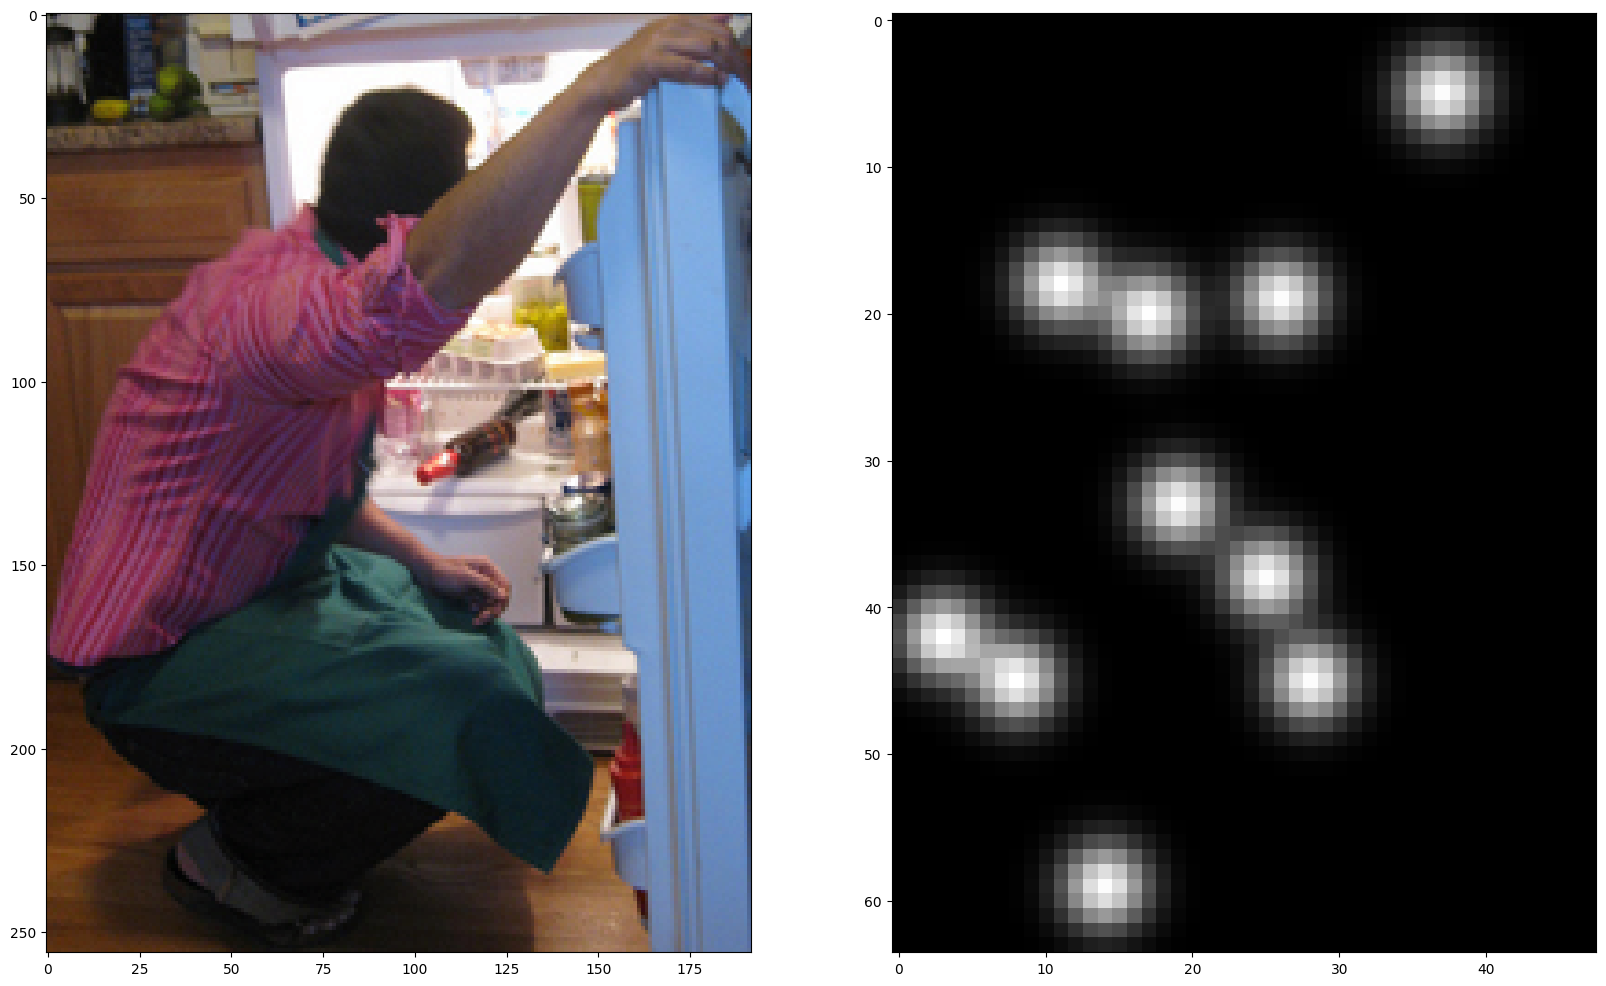

PREDICTED HEATMAP
Image:  (1, 3, 256, 192) float32 2.64 -2.117904
Heatmap:  (1, 17, 64, 48) float32 0.72576076 -0.024702594
Validity:  (1, 17) float32


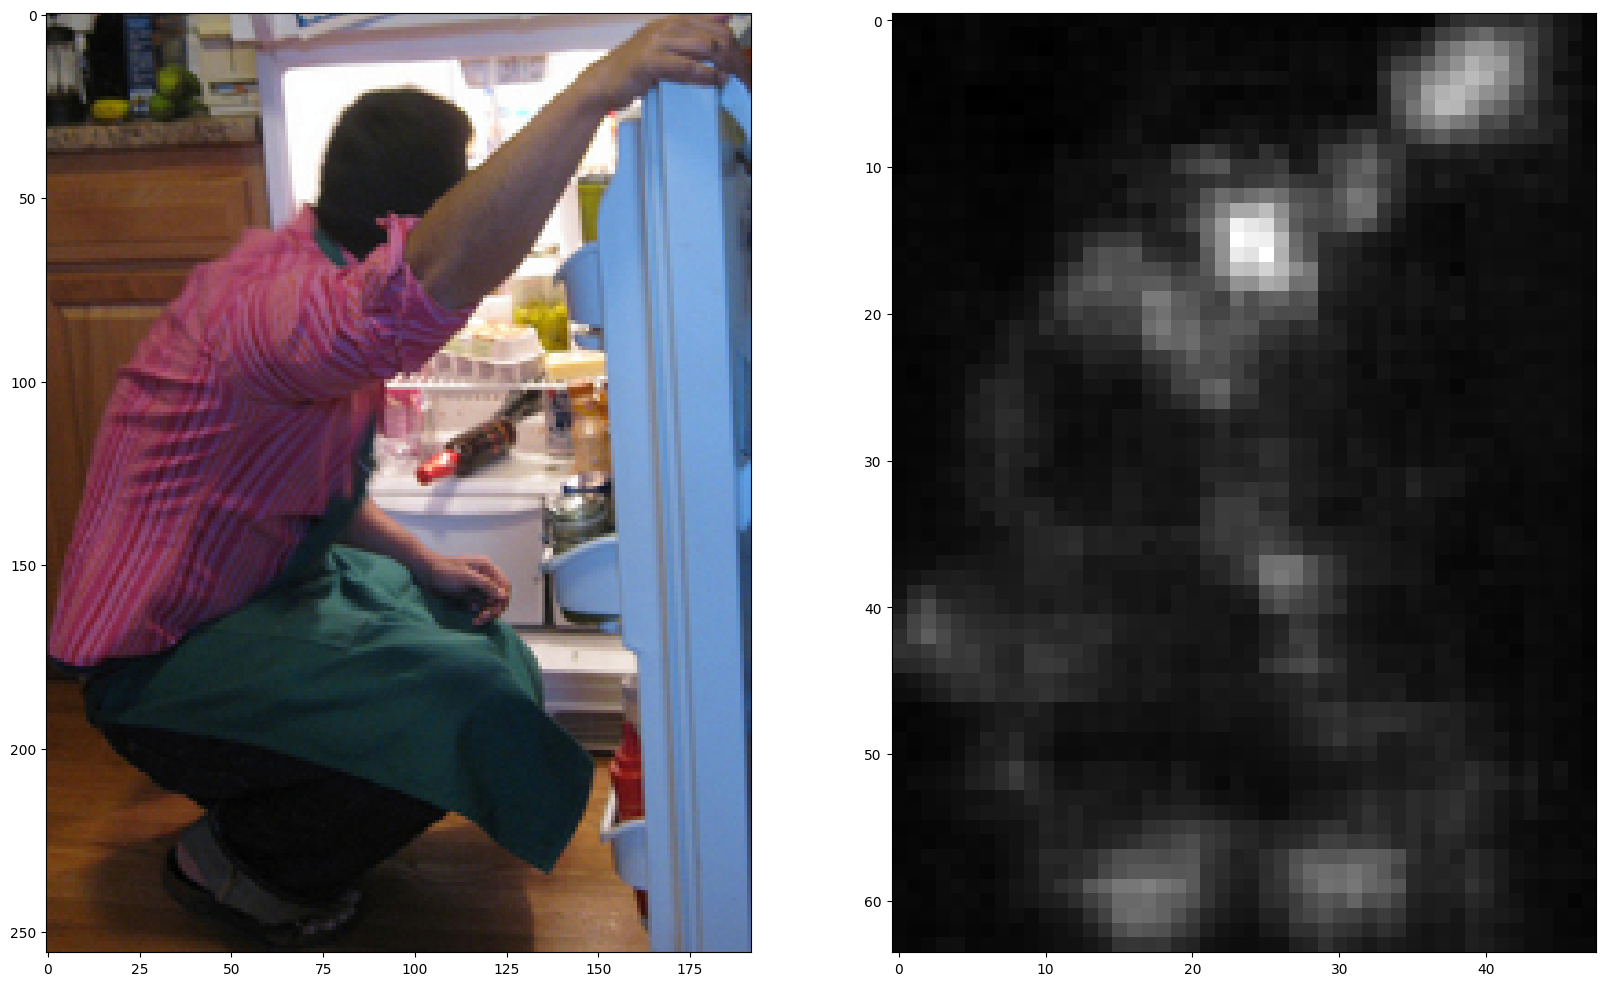

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

# heatmap plotting function
def plot_data(img_t,heatmap_t,validity_t, string):

  # convet to numpy
  img = img_t.cpu().numpy()
  heatmap = heatmap_t.cpu().numpy()
  validity = validity_t.cpu().numpy()
  
  # print stats
  print("Image: ", img.shape, img.dtype, np.max(img), np.min(img))
  print("Heatmap: ", heatmap.shape, heatmap.dtype, np.max(heatmap), np.min(heatmap))
  print("Validity: ", validity.shape, validity.dtype)
  
  # prepare data
  img = img[0].squeeze().transpose(1,2,0)
  mean=np.asarray([0.485, 0.456, 0.406])
  std=np.asarray([0.229, 0.224, 0.225])
  img = img*std + mean
  heatmap = np.sum(heatmap[0],axis=0)
  
  # plot data
  fig = plt.figure(2,figsize=(20,20))
  plt.gray()  # show the filtered result in grayscale
  ax1 = fig.add_subplot(121)  # left side
  ax1.imshow(img)
  ax2 = fig.add_subplot(122)  # right side
  ax2.imshow(heatmap)
  plt.savefig(string)
  plt.show()

# get sample from validation set
sample_batched = next(iter(val_loader))
input_img = sample_batched['input_img'][None,0].to('cuda')
heatmap = sample_batched['heatmap'][None,0].to('cuda')
validity = sample_batched['validity'][None,0].to('cuda')

# run inference on model
model.eval()
with torch.no_grad():
  output = model(input_img)

# plot groundtruth heatmap
print ("GROUNDTRUTH HEATMAP")
plot_data(input_img,heatmap,validity, 'groundtruth_heatmap.jpg')

# plot predicted heatmap
print ("PREDICTED HEATMAP")
plot_data(input_img,output,validity, 'predicted_heatmap.jpg')
plt.savefig()
